In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))
print(root_dir)

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme


In [2]:
import numpy as np
from inference.network import Network

In [93]:
n_steps = 100
arrays = {
    "eps": np.linspace(0.,np.sqrt(1/2.),n_steps),
    "eta": np.linspace(0.,1.,n_steps),
    "nu_bar": np.linspace(0.,20.,n_steps+1)[1:],
    "alpha_0": np.linspace(0.,0.12,n_steps+1)[1:],
    "tau_I": np.linspace(0.,0.1,n_steps+1)[1:]
}

def update_key(net,key,val,ranges=None):
    if ranges is None:
        ranges = [-1, -1, -1]
    if key in ["eps", "eta"]:
        setattr(net,key, val)
    elif key in ["nu_bar","alpha_0"]:

        iter_populations = range(net.n_pop) if ranges[1] == -1 else [ranges[1]]

        for p in iter_populations:
            setattr(net.populations[p],key, val)
    else:
        iter_populations = range(net.n_pop) if ranges[1] == -1 else [ranges[1]]
        for p in iter_populations:
            iter_synapses = range(len(net.populations[p].synapses)) if ranges[2] == -1 else [ranges[2]]
            for s in iter_synapses:
                setattr(net.populations[p].synapses[s],key, val)

In [130]:
net = Network(eps=np.sqrt(1/2.),eta=0.9)
net.register_population(nu_bar=1., alpha_0=0.02, J0=-1.)
net.populations[0].register_synapse(tau_I=0.03, r_I=1., tau_norm=1.)
net.register_population(nu_bar=1., alpha_0=0.02, J0=1.)
net.populations[1].register_synapse(tau_I=0.005, r_I=1., tau_norm=1.)

results = {}
for key in ["gamma", "nu_max", "chi", "delta", "sigma_V", "alpha"]:
    results[key] = np.full((net.n_pop,n_steps,n_steps),np.nan)
for key in ["is_selfconsistent", "is_dark_matter", "is_no_peak", "is_implausible"]:
    results[key] = np.full((net.n_pop,n_steps,n_steps),False,bool)

result_keys = list(results.keys())
x_key = "tau_I"
x_ranges = [0,0,0]
y_key = "alpha_0"
y_ranges = [0,-1,0]

for j,y_val in enumerate(arrays[y_key]):
    update_key(net,y_key,y_val,y_ranges)

    for i,x_val in enumerate(arrays[x_key]):
        update_key(net,x_key,x_val,x_ranges)

        if net.solve_selfcon():

            for p in range(net.n_pop):

                for key in results.keys():
                    results[key][p,j,i] = getattr(net.populations[p], key)

results["regions"] = np.zeros((net.n_pop,n_steps,n_steps))
results["regions"][results["is_no_peak"].astype(bool)] = 2
results["regions"][~results["is_selfconsistent"].astype(bool)] = 3

IMPLEMENT CALCULATING (approximating?) IMPLAUSIBLE REGION
IMPLEMENT CALCULATING (approximating?) IMPLAUSIBLE REGION


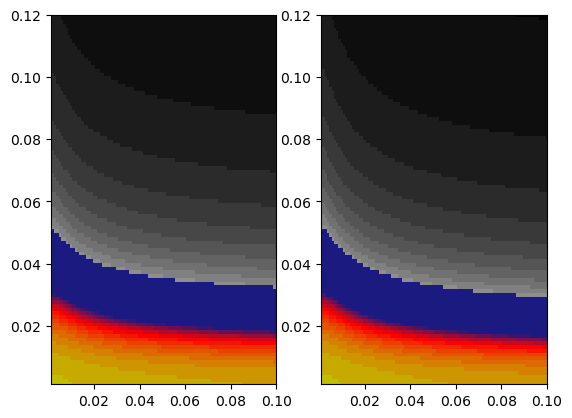

In [131]:
from matplotlib import pyplot as plt
from general_utils.plots import plot_fins

fig,axes = plt.subplots(1,2)

for p in range(net.n_pop):
    plot_fins(axes[p], arrays[x_key], arrays[y_key], results["gamma"][p,...], results["chi"][p,...],results["regions"][p,...],results["is_implausible"][p,...])

## Proper plot of distributions, depending on parameters

IMPLEMENT CALCULATING (approximating?) IMPLAUSIBLE REGION
IMPLEMENT CALCULATING (approximating?) IMPLAUSIBLE REGION


/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/inference/network.py:299: RuntimeWarning: divide by zero encountered in divide
  distr = self.gamma/(self.nu_max*np.sqrt(-np.pi*np.log(rate_ratio)))* \


interactive(children=(FloatSlider(value=0.02, description='eps', max=0.7071067811865476, step=0.001), FloatSli…

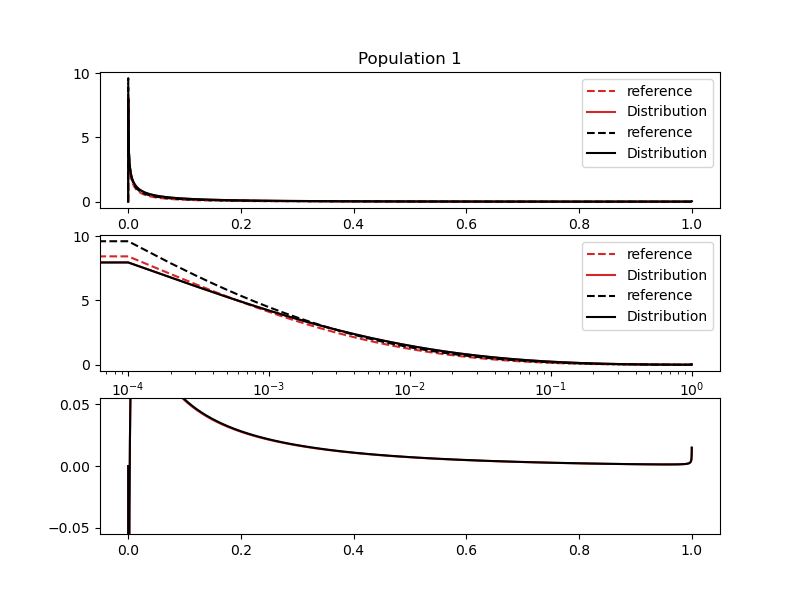

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, VBox

%matplotlib ipympl

net = Network(eps=0.3,eta=0.6)
net.register_population(nu_bar=1., alpha_0=0.02, J0=-1.)
net.populations[0].register_synapse(tau_I=0.03, r_I=1., tau_norm=1.)
net.register_population(nu_bar=1., alpha_0=0.02, J0=1.)
net.populations[1].register_synapse(tau_I=0.005, r_I=1., tau_norm=1.)
net.solve_selfcon()
n_steps = 10000
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(311)
ax_log = fig.add_subplot(312)
ax_diff = fig.add_subplot(313)


handles = []
handles_log = []
handles_diff = []
colors = ["tab:red","k"]

rho_ref = np.zeros((2,n_steps))
for p_idx,pop in enumerate(net.populations):
    nu,rho_ref[p_idx] = pop.distribution(n_steps)
    ax.plot(nu, rho_ref[p_idx], color=colors[p_idx], linestyle='--', label='reference')
    ax_log.plot(nu, rho_ref[p_idx], color=colors[p_idx], linestyle='--', label='reference')
    handle, = ax.plot(nu, rho_ref[p_idx], color=colors[p_idx], label='Distribution')
    handles.append(handle)
    handle, = ax_log.plot(nu, rho_ref[p_idx], color=colors[p_idx], label='Distribution')
    handles_log.append(handle)

    handle, = ax_diff.plot(nu, np.zeros_like(rho_ref[p_idx]), color=colors[p_idx], label='Difference')
    handles_diff.append(handle)
ax.set_title(f'Population {p}')
ax.legend()
ax_log.legend()
ax_log.set_xscale('log')

key_1 = "eps"
key_2 = "eta"

ranges_1 = [0, -1, 0]
ranges_2 = [0, 1, -1]

def update_distributions(val_1, val_2):
    # Update network parameters
    update_key(net, key_1, val_1, ranges_1)
    update_key(net, key_2, val_2, ranges_2)
    net.solve_selfcon()

    for p in range(net.n_pop):
        _,rho = net.populations[p].distribution(n_steps)
        handles[p].set_ydata(rho)
        handles_log[p].set_ydata(rho)
        handles_diff[p].set_ydata(rho - rho_ref)
    fig.canvas.draw_idle()
    

slider_1 = FloatSlider(min=arrays[key_1].min(), max=arrays[key_1].max(), step=0.001, value=0.02, description=key_1)
slider_2 = FloatSlider(min=arrays[key_2].min(), max=arrays[key_2].max(), step=0.001, value=0.03, description=key_2)

interact(update_distributions, val_1=slider_1, val_2=slider_2)
plt.show()

In [529]:
options = set_options(L=1, nI=1, nE=1)

for key in ["eps","eta"]:
    options[key] = getattr(net,key)

for key in ["nu_bar","alpha_0","J0"]:
    options[key] = []
    for p,pop in enumerate(net.populations):
        options[key].append(getattr(pop,key))

for key in ["tau_I","r_I","tau_norm"]:
    options[key] = []
    for p,pop in enumerate(net.populations):
        for s,syn in enumerate(pop.synapses):
            
            options[key].append(getattr(syn,key))

# options["tau_I"].append(0.2)
# options["tau_norm"].append(1.)
options["S"] = [1,1]
options["tau_n"] = 0.
options["rateWnt"] = options["nu_bar"]
options["mode_stats"] = 1
# net.print_current_state()
options


{'L': 1,
 'P': 2,
 'S': [1, 1],
 'eps': 0.6,
 'eta': 0.4,
 'J0_l': array([[0.]]),
 'I_ext': -1.0,
 'rateWnt': [2.0, np.float64(20.0)],
 'kappa': [1.0, 1.0],
 'alpha_0': [0.02, np.float64(0.08)],
 'Psi_0': 0.0,
 'tau_M': 0.01,
 'J0': [-1.0, 1.0],
 'tau_I': [0.03, 0.005],
 'tau_n': 0.0,
 'tau_norm': [1.0, 1.0],
 'mode': 0,
 'mode_stats': 1,
 'mode_calc': 0,
 'mode_selfcon': 0,
 'simulation': {},
 'nu_bar': [2.0, np.float64(20.0)],
 'r_I': [1.0, 1.0]}

In [530]:
# options = set_options(L=1, nI=1, nE=1)
options["simulation"] = {
    # "eps": [0.0, np.sqrt(1.0 / 2)],
    # "eta": [0.,1.],
    # "tau_I": [0., 0.1],
    "rateWnt": [0, 20.0],
    "alpha_0": [0, 0.08],
    "sim_prim": [0, 1, 0],
    "sim_sec": [0, 1, 0],
    # "mode_stats": [1],
}
# print(options)

res = darkMatter(steps=100, options=options, rerun=True, compile=True, logging=1)

DM suffix: 
rateWnt [0, 20.0] <class 'list'>
alpha_0 [0, 0.08] <class 'list'>
sim_prim [0, 1, 0] <class 'list'>
sim_sec [0, 1, 0] <class 'list'>
rateWnt [ 0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8
  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4  5.6
  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2  8.4
  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6 16.8
 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4 19.6
 19.8 20. ]
alpha_0 [0.0008 0.0016 0.0024 0.0032 0.004  0.0048 0.0056 0.0064 0.0072 0.008
 0.0088 0.0096 0.0104 0.0112 0.012  0.0128 0.0136 0.0144 0.0152 0.016
 0.0168 0.0176 0.0184 0.0192 0.02   0.0208 0.0216 0.0224 0.0232 0.024
 0.0248 0.0256 0.0264 0.0272 0.028  0.0288 0.0296 0.0304 0.0312 0.032
 0.0328 0.0336 0.0344 0.0352 0.036  0.0368 0.0376 0

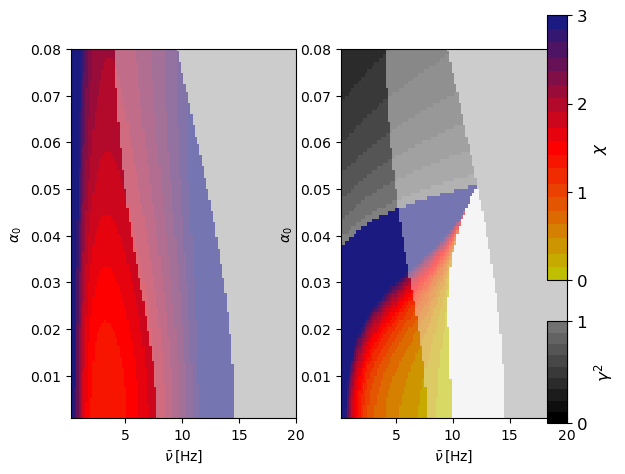

In [531]:
from general_utils.plots import plot_fins, get_displayString, plot_colorbar
order = [o for o in list(options["simulation"]) if not o.startswith("sim")]

fig, ax = plt.subplots(1, 2)
## plotting sharkfins for each solution
for p in range(res["gamma"].shape[0]):
    pchi, pgamma = plot_fins(
        ax[p],
        res[order[0]],
        res[order[1]],
        res["gamma"][p, ...],
        res["chi"][p, ...],
        res["regions"][p, ...],
        implausible=res["implausible"][p, ...],
    )
    plt.setp(
        ax[p], xlabel=get_displayString(order[0]), ylabel=get_displayString(order[1])
    )

plot_colorbar(pchi, pgamma, x=[0.87, 0.9], y=[0.1, 0.95])

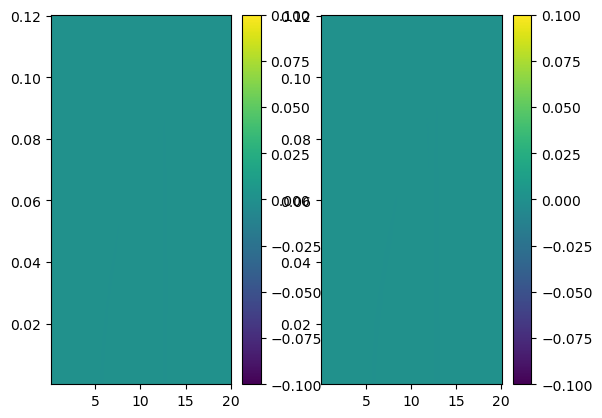

In [458]:
#gamma.shape#
fig,axes = plt.subplots(1,2)

for p in range(net.n_pop):
    im = axes[p].pcolormesh(arrays[x_key], arrays[y_key], (res["gamma"][p,...] - gamma[p,...]), vmin=-0.1, vmax=0.1)
    plt.colorbar(im, ax=axes[p])


In [522]:
print(res["alpha"][1,...])
print(alpha[1,...])

[[0.04533716 0.04536103 0.04572972 0.0468454  0.04855854 0.05067924
  0.05305726 0.05558738 0.05819949 0.06084799]
 [0.04743818 0.04749108 0.04785966 0.04892532 0.05055236 0.05256856
  0.05483692 0.05726013 0.05977206 0.06232866]
 [0.05074144 0.05083088 0.05119626 0.05219084 0.05369682 0.05556488
  0.05767566 0.05994293 0.06230659 0.06472534]
 [0.05502516 0.05514887 0.05550612 0.05641994 0.05779053 0.05949151
  0.06142173 0.06350704 0.06569454 0.0679467 ]
 [0.06007513 0.06022529 0.06056923 0.06140112 0.06263699 0.06417061
  0.06591716 0.06781398 0.06981549 0.07188857]
 [0.0657117  0.06587898 0.0662055  0.06695932 0.06806953 0.06944638
  0.07101865 0.07273358 0.07455241 0.07644643]
 [0.0717951  0.07197116 0.07227767 0.07295974 0.07395688 0.0751924
  0.0766059  0.0781528  0.07980022 0.08152351]
 [0.07822049 0.07839888 0.07868426 0.07930176 0.08019912 0.08130988
  0.08258216 0.08397791 0.08546907 0.08703458]
 [0.08491023 0.08508644 0.08535072 0.08591081 0.08672097 0.08772282
  0.08887113 

In [270]:
res["alpha_0"]

masked_array(data=[0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
                   0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032,
                   0.034, 0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048,
                   0.05 , 0.052, 0.054, 0.056, 0.058, 0.06 , 0.062, 0.064,
                   0.066, 0.068, 0.07 , 0.072, 0.074, 0.076, 0.078, 0.08 ,
                   0.082, 0.084, 0.086, 0.088, 0.09 , 0.092, 0.094, 0.096,
                   0.098, 0.1  , 0.102, 0.104, 0.106, 0.108, 0.11 , 0.112,
                   0.114, 0.116, 0.118, 0.12 , 0.122, 0.124, 0.126, 0.128,
                   0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142, 0.144,
                   0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
                   0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176,
                   0.178, 0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192,
                   0.194, 0.196, 0.198, 0.2  ],
             mask=False,
       fill_value=1e+20)